In [59]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, LSTM, RepeatVector
from keras.models import Model
from keras.models import model_from_json
from keras import regularizers
import datetime
import time
import requests as req
import json
import pandas as pd
import pickle
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [36]:
## USE: full log(returns)/returns dataframe
## Risk Adjusted Returns

df = pd.read_pickle("../Data/risk_adj_returns.pkl").iloc[1:]

drop_columns = []
for col in df.columns:
    if df[col].isnull().all() == True:
        drop_columns.append(col)
        
df.drop(columns=drop_columns, inplace=True)

# df['pct_change'] = df.close.pct_change()
# df['log_ret'] = np.log(df.close) - np.log(df.close.shift(1))
# df = df.dropna()

In [37]:
#df = df.dropna(how='any',axis=0) #All rows have NaN

In [38]:
df.tail()

,905270,921795,904261,905261,916328,923024,936365,902355,912215,929813,...,9660J1,69568X,543755,77463M,29235J,131745,69487D,68157P,9110RA,292703
date,,,,,,,,,,,,,,,,,,,,,
2021-05-24,NaN,NaN,NaN,NaN,-0.073424,NaN,-0.026594,NaN,NaN,NaN,...,-0.042002,0.042352,-0.007893,-0.034946,-0.006981,0.025437,0.006211,-0.034570,0.045914,-0.023507
2021-05-25,NaN,NaN,NaN,NaN,-0.041516,NaN,-0.023492,NaN,NaN,NaN,...,-0.045774,-0.040381,-0.029872,-0.042776,-0.034353,-0.047507,-0.041449,-0.032225,-0.001858,-0.073776
2021-05-26,NaN,NaN,NaN,NaN,-0.133718,NaN,-0.022297,NaN,NaN,NaN,...,-0.018214,0.006846,-0.041720,0.014670,0.006996,0.050378,-0.030298,0.008515,-0.039008,-0.103963
2021-05-27,NaN,NaN,NaN,NaN,-0.114582,NaN,-0.030586,NaN,NaN,NaN,...,-0.050278,-0.001888,-0.039754,-0.029330,-0.021043,-0.042413,-0.000474,-0.003118,-0.012079,0.010919
2021-05-28,NaN,NaN,NaN,NaN,-0.046110,NaN,0.001882,NaN,NaN,NaN,...,-0.059837,-0.051037,-0.046412,-0.017292,-0.040496,-0.066158,-0.032654,-0.031242,-0.039250,-0.007592


In [39]:
def get_investable(t, n_rows):
    "Find stocks in investable universe at time t\
    (stocks in the S&P500 that have prices recorded for the last n_rows days)"
    
    df_investable = df.copy(deep = True).sort_index(ascending = False)
    
    #add 1 date to get the test features in investable
    t = t + pd.DateOffset(1)
    
    #if t is now a non-trading day, advance until we reach a valid trading day
    while t not in df_investable.index:
        t = t + pd.DateOffset(1)
    
    t_index = df_investable.index.get_loc(t)
    
    #take n_rows worth of data upto time specified
    df_investable = df_investable.iloc[t_index + 1:t_index + n_rows + 1]
    
    #find all stocks that exist in the S&P at this time period
    investable_universe = []
    for col in df_investable.columns:
        if ~df_investable[col].iloc[:n_rows].isna().any():
            investable_universe.append(col)
        
    df_investable = df_investable[investable_universe]
    
    return df_investable

In [40]:
df = get_investable(pd.to_datetime('2018-05-11'), 200)
df

,916328,936365,905271,905113,905802,905425,906156,916305,992816,921093,...,311917,69568X,543755,77463M,29235J,131745,69487D,68157P,9110RA,292703
date,,,,,,,,,,,,,,,,,,,,,
2018-05-11,-0.033261,-0.056147,-0.056673,-0.039225,-0.078155,-0.079176,-0.055281,-0.036198,-0.062879,-0.060282,...,-0.030098,-0.058198,-0.028429,-0.050278,-0.080133,-0.024472,-0.052140,-0.019944,-7.289672e-02,-0.031952
2018-05-10,-0.001857,-0.007957,-0.056608,-0.033577,-0.012766,-0.038382,-0.031704,-0.042638,-0.012963,-0.051148,...,-0.056529,-0.045813,-0.015254,0.108949,-0.000408,-0.018463,-0.030641,-0.039673,7.790037e-03,-0.075911
2018-05-09,-0.032497,0.014964,-0.041537,-0.019209,0.009759,-0.152829,-0.034908,-0.049782,-0.029491,-0.085189,...,0.030915,-0.006775,-0.098720,0.026074,-0.007489,-0.041385,-0.049166,-0.000544,-3.590120e-02,-0.052591
2018-05-08,-0.119326,-0.029451,-0.070543,-0.015943,0.022881,-0.186745,-0.023214,-0.047493,-0.034577,-0.046590,...,-0.051192,-0.039952,-0.071749,-0.048822,-0.039231,0.017063,-0.038039,-0.024803,-2.449209e-02,-0.070835
2018-05-07,-0.039900,0.012059,-0.056630,-0.000645,-0.030319,-0.127271,-0.049799,-0.023339,-0.029050,-0.079179,...,-0.046167,0.016789,0.003434,0.055430,-0.044564,-0.025124,-0.087165,0.004368,-4.533198e-02,-0.074954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-02,-0.072393,-0.072199,-0.091406,-0.072376,-0.001441,-0.069006,-0.054409,-0.027164,0.062017,-0.128361,...,-0.066717,-0.000397,-0.034413,-0.047709,-0.072616,-0.041856,-0.050222,-0.016288,-8.383439e-03,-0.039350
2017-08-01,-0.081210,-0.020391,0.099262,-0.018858,-0.136634,-0.083397,-0.056063,-0.039072,-0.025318,0.021731,...,-0.054461,-0.056564,-0.034920,0.007488,-0.025096,-0.018787,-0.029751,0.011307,-3.998029e-02,-0.038914
2017-07-31,-0.112960,-0.071512,-0.105417,-0.066444,-0.069153,-0.081507,-0.042095,-0.034474,-0.057237,-0.034575,...,-0.058288,-0.096375,-0.038522,-0.056268,-0.050467,-0.035428,-0.043417,-0.056971,2.785112e-17,-0.038776


In [41]:
tts = train_test_split(df, test_size=0.2, shuffle=False)
train = tts[0]
test = tts[1]

In [42]:
train.tail()

,916328,936365,905271,905113,905802,905425,906156,916305,992816,921093,...,311917,69568X,543755,77463M,29235J,131745,69487D,68157P,9110RA,292703
date,,,,,,,,,,,,,,,,,,,,,
2017-09-28,0.033774,-0.032232,-0.071387,-0.084644,-0.076437,-0.076465,-0.035913,-0.049128,-0.059533,-0.089435,...,-0.053948,-0.042377,-0.044853,0.024979,-0.039263,-0.017803,-0.042860,-0.043971,-0.016182,-0.061822
2017-09-27,-0.130996,0.005307,-0.063771,-0.039784,-0.017728,-0.143054,-0.030959,-0.014198,-0.029317,-0.102140,...,-0.050615,-0.057166,-0.010357,0.044859,0.029447,-0.029128,-0.038377,-0.028755,0.010398,-0.014246
2017-09-26,-0.060831,-0.052681,-0.084904,-0.036838,-0.040810,-0.079077,-0.041050,-0.057685,-0.006364,-0.070131,...,-0.062638,-0.033960,-0.045905,-0.014777,-0.020430,-0.003253,-0.046713,-0.067935,-0.022240,-0.070503
2017-09-25,-0.071303,-0.115842,-0.041493,-0.057992,0.042759,-0.058970,-0.062454,-0.030108,-0.065593,-0.051800,...,-0.045482,-0.065947,-0.069041,-0.064799,-0.071611,-0.040592,-0.050160,-0.048418,-0.053214,-0.049827
2017-09-22,0.003938,-0.045452,-0.090654,-0.104774,-0.000160,-0.142855,-0.057031,-0.033048,-0.067770,-0.059431,...,-0.060346,-0.109388,-0.023386,-0.023368,-0.035876,-0.042236,-0.047319,-0.029264,-0.056097,-0.055420


In [43]:
test.tail()

,916328,936365,905271,905113,905802,905425,906156,916305,992816,921093,...,311917,69568X,543755,77463M,29235J,131745,69487D,68157P,9110RA,292703
date,,,,,,,,,,,,,,,,,,,,,
2017-08-02,-0.072393,-0.072199,-0.091406,-0.072376,-0.001441,-0.069006,-0.054409,-0.027164,0.062017,-0.128361,...,-0.066717,-0.000397,-0.034413,-0.047709,-0.072616,-0.041856,-0.050222,-0.016288,-8.383439e-03,-0.039350
2017-08-01,-0.081210,-0.020391,0.099262,-0.018858,-0.136634,-0.083397,-0.056063,-0.039072,-0.025318,0.021731,...,-0.054461,-0.056564,-0.034920,0.007488,-0.025096,-0.018787,-0.029751,0.011307,-3.998029e-02,-0.038914
2017-07-31,-0.112960,-0.071512,-0.105417,-0.066444,-0.069153,-0.081507,-0.042095,-0.034474,-0.057237,-0.034575,...,-0.058288,-0.096375,-0.038522,-0.056268,-0.050467,-0.035428,-0.043417,-0.056971,2.785112e-17,-0.038776
2017-07-28,-0.118123,-0.051635,-0.075864,-0.067341,-0.003632,-0.103423,-0.024447,-0.036920,-0.061538,-0.066325,...,-0.081006,-0.032072,-0.057375,-0.008117,-0.085291,-0.091201,-0.048182,-0.059747,-5.193123e-02,-0.086363
2017-07-27,-0.101479,-0.102112,-0.078104,-0.096516,-0.022157,-0.010757,-0.104324,-0.040602,-0.088521,-0.060760,...,-0.047624,-0.083475,-0.066640,-0.092776,-0.089591,-0.087135,-0.037175,-0.049250,-7.456348e-02,-0.088761


In [44]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train)
test_set_scaled = sc.fit_transform(test)
pd.DataFrame(training_set_scaled).head()

,0,1,2,3,4,5,6,7,8,9,...,640,641,642,643,644,645,646,647,648,649
0,0.661406,0.441272,0.526470,0.828958,0.460741,0.520905,0.428907,0.635693,0.393566,0.529545,...,0.343729,0.461508,0.571224,0.259734,0.385493,0.413940,0.525361,0.613774,0.145999,0.745686
1,0.749938,0.551324,0.526684,0.837788,0.648450,0.707915,0.492168,0.598313,0.634965,0.560486,...,0.270439,0.505696,0.629955,0.714857,0.675644,0.429399,0.575786,0.548986,0.374450,0.664123
2,0.663560,0.603668,0.576641,0.860254,0.713111,0.183266,0.483571,0.556848,0.555032,0.445173,...,0.512915,0.644981,0.257864,0.477973,0.649873,0.370430,0.532337,0.677480,0.250746,0.707392
3,0.418774,0.502238,0.480496,0.865360,0.750778,0.027789,0.514947,0.570130,0.530440,0.575925,...,0.285238,0.526607,0.378104,0.263895,0.534352,0.520791,0.558434,0.597818,0.283049,0.673541
4,0.642690,0.597032,0.526614,0.889280,0.598061,0.300429,0.443615,0.710329,0.557165,0.465532,...,0.299173,0.729053,0.713267,0.561883,0.514943,0.412264,0.443215,0.693610,0.224044,0.665899


## Simple multi-layer percepetron (MLP) autoencoder

In [45]:
# calculated log returns (i.e. the log of the difference between the price x+1 and price x)
# windows of train.shape[1] consecutive returns will be produced. 
# Can be normalized with a MinMaxScaler to the range [0,1]??

window_length = training_set_scaled.shape[1]
encoding_dim = 3
epochs = 500

# compress the input to a 3-dimensional latent space. 

# input placeholder
input_window = Input(shape=(window_length,))
# encoded representation of the input
encoded = Dense(encoding_dim, activation='tanh')(input_window) #tanh, linear, leakyrelu
# lossy reconstruction of the input
decoded = Dense(window_length, activation='linear')(encoded) #linear

# model mapping an input to its reconstruction
autoencoder = Model(input_window, decoded)

# model mapping an input to its encoded representation
encoder = Model(input_window, encoded)


autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='MeanSquaredError') #MSE
history = autoencoder.fit(training_set_scaled, training_set_scaled,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_split = 0.2)       
#                 validation_data=(test_set_scaled, test_set_scaled))

decoded_stocks = autoencoder.predict(test_set_scaled)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 650)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 1953      
_________________________________________________________________
dense_3 (Dense)              (None, 650)               2600      
Total params: 4,553
Trainable params: 4,553
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
1/1 [==============================] - 1s 1s/step - loss: 0.3036 - val_loss: 0.2993
Epoch 2/500
1/1 [==============================] - 0s 61ms/step - loss: 0.3014 - val_loss: 0.2972
Epoch 3/500
1/1 [==============================] - 0s 70ms/step - loss: 0.2993 - val_loss: 0.2945
Epoch 4/500
1/1 [==============================] - 0s 108ms/step - loss: 0.2967 - val_loss: 0.2

1/1 [==============================] - 0s 83ms/step - loss: 0.0338 - val_loss: 0.0279
Epoch 159/500
1/1 [==============================] - 0s 55ms/step - loss: 0.0334 - val_loss: 0.0276
Epoch 160/500
1/1 [==============================] - 0s 49ms/step - loss: 0.0331 - val_loss: 0.0273
Epoch 161/500
1/1 [==============================] - 0s 50ms/step - loss: 0.0328 - val_loss: 0.0269
Epoch 162/500
1/1 [==============================] - 0s 66ms/step - loss: 0.0325 - val_loss: 0.0266
Epoch 163/500
1/1 [==============================] - 0s 60ms/step - loss: 0.0321 - val_loss: 0.0263
Epoch 164/500
1/1 [==============================] - 0s 71ms/step - loss: 0.0318 - val_loss: 0.0260
Epoch 165/500
1/1 [==============================] - 0s 61ms/step - loss: 0.0315 - val_loss: 0.0258
Epoch 166/500
1/1 [==============================] - 0s 38ms/step - loss: 0.0312 - val_loss: 0.0255
Epoch 167/500
1/1 [==============================] - 0s 99ms/step - loss: 0.0310 - val_loss: 0.0252
Epoch 168/500


Epoch 240/500
1/1 [==============================] - 0s 117ms/step - loss: 0.0200 - val_loss: 0.0153
Epoch 241/500
1/1 [==============================] - 0s 85ms/step - loss: 0.0199 - val_loss: 0.0152
Epoch 242/500
1/1 [==============================] - 0s 82ms/step - loss: 0.0198 - val_loss: 0.0152
Epoch 243/500
1/1 [==============================] - 0s 65ms/step - loss: 0.0197 - val_loss: 0.0151
Epoch 244/500
1/1 [==============================] - 0s 50ms/step - loss: 0.0197 - val_loss: 0.0151
Epoch 245/500
1/1 [==============================] - 0s 42ms/step - loss: 0.0196 - val_loss: 0.0150
Epoch 246/500
1/1 [==============================] - 0s 51ms/step - loss: 0.0196 - val_loss: 0.0150
Epoch 247/500
1/1 [==============================] - 0s 46ms/step - loss: 0.0195 - val_loss: 0.0149
Epoch 248/500
1/1 [==============================] - 0s 69ms/step - loss: 0.0194 - val_loss: 0.0149
Epoch 249/500
1/1 [==============================] - 0s 73ms/step - loss: 0.0194 - val_loss: 0.0148

Epoch 322/500
1/1 [==============================] - 0s 55ms/step - loss: 0.0168 - val_loss: 0.0134
Epoch 323/500
1/1 [==============================] - 0s 46ms/step - loss: 0.0168 - val_loss: 0.0134
Epoch 324/500
1/1 [==============================] - 0s 42ms/step - loss: 0.0168 - val_loss: 0.0133
Epoch 325/500
1/1 [==============================] - 0s 40ms/step - loss: 0.0168 - val_loss: 0.0133
Epoch 326/500
1/1 [==============================] - 0s 70ms/step - loss: 0.0168 - val_loss: 0.0133
Epoch 327/500
1/1 [==============================] - 0s 50ms/step - loss: 0.0167 - val_loss: 0.0133
Epoch 328/500
1/1 [==============================] - 0s 47ms/step - loss: 0.0167 - val_loss: 0.0133
Epoch 329/500
1/1 [==============================] - 0s 42ms/step - loss: 0.0167 - val_loss: 0.0133
Epoch 330/500
1/1 [==============================] - 0s 53ms/step - loss: 0.0167 - val_loss: 0.0133
Epoch 331/500
1/1 [==============================] - 0s 46ms/step - loss: 0.0167 - val_loss: 0.0133


Epoch 404/500
1/1 [==============================] - 0s 126ms/step - loss: 0.0158 - val_loss: 0.0131
Epoch 405/500
1/1 [==============================] - 0s 104ms/step - loss: 0.0158 - val_loss: 0.0131
Epoch 406/500
1/1 [==============================] - 0s 76ms/step - loss: 0.0157 - val_loss: 0.0132
Epoch 407/500
1/1 [==============================] - 0s 76ms/step - loss: 0.0157 - val_loss: 0.0131
Epoch 408/500
1/1 [==============================] - 0s 92ms/step - loss: 0.0157 - val_loss: 0.0131
Epoch 409/500
1/1 [==============================] - 0s 87ms/step - loss: 0.0157 - val_loss: 0.0131
Epoch 410/500
1/1 [==============================] - 0s 99ms/step - loss: 0.0157 - val_loss: 0.0131
Epoch 411/500
1/1 [==============================] - 0s 95ms/step - loss: 0.0157 - val_loss: 0.0131
Epoch 412/500
1/1 [==============================] - 0s 53ms/step - loss: 0.0157 - val_loss: 0.0131
Epoch 413/500
1/1 [==============================] - 0s 57ms/step - loss: 0.0157 - val_loss: 0.013

In [46]:
pd.DataFrame(encoder.predict(test_set_scaled))

,0,1,2
0,0.997219,0.944816,0.966394
1,0.998349,0.973568,0.957678
2,0.997940,0.943733,0.975412
3,0.998998,0.975444,0.993826
4,0.998769,0.988266,0.993771
5,0.998554,0.946912,0.979083
6,0.998091,0.918583,0.958994
7,0.998828,0.984794,0.979714
8,0.999664,0.986845,0.996951
9,0.995219,0.892267,0.996083


In [47]:
pd.DataFrame(decoded_stocks)

,0,1,2,3,4,5,6,7,8,9,...,640,641,642,643,644,645,646,647,648,649
0,0.602029,0.534340,0.528308,0.850182,0.611104,0.507425,0.488035,0.651951,0.506625,0.579119,...,0.320729,0.600826,0.553998,0.391519,0.567897,0.414377,0.545895,0.546801,0.299661,0.745794
1,0.606245,0.537300,0.532513,0.856057,0.612496,0.511252,0.488982,0.656954,0.511792,0.580247,...,0.320500,0.604097,0.558255,0.392923,0.570007,0.415443,0.551795,0.548511,0.302581,0.748608
2,0.603670,0.535562,0.529603,0.851949,0.613004,0.508727,0.489753,0.653561,0.507100,0.581100,...,0.321700,0.602515,0.555094,0.392149,0.569365,0.415168,0.546309,0.547907,0.300242,0.747958
3,0.613798,0.542850,0.538759,0.864232,0.620366,0.517471,0.496109,0.664572,0.514541,0.588619,...,0.324287,0.611622,0.563594,0.395554,0.576323,0.418675,0.554445,0.553041,0.305621,0.757997
4,0.616340,0.544645,0.541208,0.867482,0.621658,0.519757,0.497166,0.667472,0.516972,0.589912,...,0.324503,0.613739,0.565947,0.396343,0.577800,0.419376,0.557186,0.554107,0.307199,0.760097
5,0.605106,0.536609,0.530847,0.853677,0.614213,0.509927,0.490803,0.655082,0.508041,0.582313,...,0.322196,0.603854,0.556242,0.392678,0.570435,0.415740,0.547314,0.548736,0.300937,0.749492
6,0.595403,0.529624,0.522109,0.842056,0.606960,0.501555,0.484495,0.644585,0.501239,0.574826,...,0.319561,0.595066,0.548197,0.389454,0.563681,0.412365,0.539907,0.543819,0.295864,0.739690
7,0.612889,0.542129,0.538270,0.863666,0.618366,0.516862,0.494200,0.663918,0.515424,0.586403,...,0.323009,0.610393,0.563390,0.395184,0.575062,0.418003,0.555610,0.552168,0.305686,0.756033
8,0.616788,0.544996,0.541504,0.867984,0.622333,0.520065,0.497766,0.667876,0.517040,0.590565,...,0.324889,0.614244,0.566199,0.396581,0.578283,0.419680,0.557209,0.554533,0.307293,0.760780
9,0.597031,0.530922,0.522852,0.842331,0.611448,0.502657,0.488933,0.645521,0.498061,0.580150,...,0.322557,0.597566,0.548102,0.389886,0.566335,0.413595,0.535938,0.545302,0.295386,0.744077


In [48]:
def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 2, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")

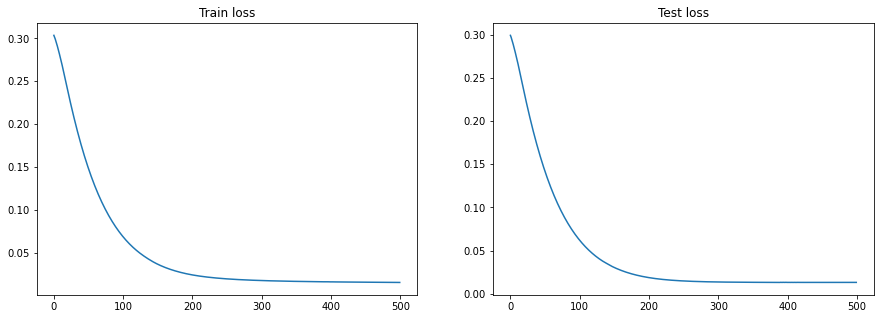

In [49]:
# Loss vs Epoch
plot_history(history)

## 1D convolutional autoencoder
(Kernel size = 3)

In [50]:
# main “event” very well represented while the overall reconstruction is very smooth 

input_window = Input(shape=(window_length,1))
x = Conv1D(16, 3, activation="tanh", padding="same")(input_window) # 10 dims
#x = BatchNormalization()(x)
x = MaxPooling1D(2, padding="same")(x) # 5 dims
x = Conv1D(1, 3, activation="tanh", padding="same")(x) # 5 dims
#x = BatchNormalization()(x)
encoded = MaxPooling1D(2, padding="same")(x) # 3 dims
encoder = Model(input_window, encoded)

# 3 dimensions in the encoded layer

x = Conv1D(1, 3, activation="tanh", padding="same")(encoded) # 3 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x) # 6 dims
x = Conv1D(16, 2, activation='tanh')(x) # 5 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x) # 10 dims
decoded = Conv1D(1, 3, activation='linear', padding='same')(x) # 10 dims
autoencoder = Model(input_window, decoded)
autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='MeanSquaredError')
history = autoencoder.fit(training_set_scaled, training_set_scaled,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_split = 0.2)

decoded_stocks = autoencoder.predict(test)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 650, 1)]          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 650, 16)           64        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 325, 16)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 325, 1)            49        
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 163, 1)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 163, 1)            4         
_________________________________________________________________
up_sampling1d_2 (UpSampling1 (None, 326, 1)            0   

1/1 [==============================] - 0s 263ms/step - loss: 0.0304 - val_loss: 0.0269
Epoch 148/500
1/1 [==============================] - 0s 201ms/step - loss: 0.0304 - val_loss: 0.0268
Epoch 149/500
1/1 [==============================] - 0s 224ms/step - loss: 0.0304 - val_loss: 0.0268
Epoch 150/500
1/1 [==============================] - 0s 259ms/step - loss: 0.0304 - val_loss: 0.0268
Epoch 151/500
1/1 [==============================] - 0s 223ms/step - loss: 0.0304 - val_loss: 0.0268
Epoch 152/500
1/1 [==============================] - 0s 187ms/step - loss: 0.0303 - val_loss: 0.0268
Epoch 153/500
1/1 [==============================] - 0s 167ms/step - loss: 0.0303 - val_loss: 0.0268
Epoch 154/500
1/1 [==============================] - 0s 185ms/step - loss: 0.0303 - val_loss: 0.0268
Epoch 155/500
1/1 [==============================] - 0s 269ms/step - loss: 0.0303 - val_loss: 0.0268
Epoch 156/500
1/1 [==============================] - 0s 265ms/step - loss: 0.0303 - val_loss: 0.0268
Epoc

1/1 [==============================] - 0s 289ms/step - loss: 0.0274 - val_loss: 0.0255
Epoch 310/500
1/1 [==============================] - 0s 231ms/step - loss: 0.0273 - val_loss: 0.0255
Epoch 311/500
1/1 [==============================] - 0s 336ms/step - loss: 0.0273 - val_loss: 0.0255
Epoch 312/500
1/1 [==============================] - 0s 277ms/step - loss: 0.0273 - val_loss: 0.0255
Epoch 313/500
1/1 [==============================] - 0s 286ms/step - loss: 0.0273 - val_loss: 0.0255
Epoch 314/500
1/1 [==============================] - 0s 267ms/step - loss: 0.0273 - val_loss: 0.0255
Epoch 315/500
1/1 [==============================] - 0s 235ms/step - loss: 0.0273 - val_loss: 0.0255
Epoch 316/500
1/1 [==============================] - 0s 280ms/step - loss: 0.0273 - val_loss: 0.0255
Epoch 317/500
1/1 [==============================] - 0s 300ms/step - loss: 0.0273 - val_loss: 0.0255
Epoch 318/500
1/1 [==============================] - 0s 246ms/step - loss: 0.0273 - val_loss: 0.0255
Epoc

1/1 [==============================] - 0s 245ms/step - loss: 0.0264 - val_loss: 0.0248
Epoch 472/500
1/1 [==============================] - 0s 298ms/step - loss: 0.0264 - val_loss: 0.0248
Epoch 473/500
1/1 [==============================] - 0s 256ms/step - loss: 0.0264 - val_loss: 0.0248
Epoch 474/500
1/1 [==============================] - 0s 231ms/step - loss: 0.0264 - val_loss: 0.0248
Epoch 475/500
1/1 [==============================] - 0s 268ms/step - loss: 0.0264 - val_loss: 0.0248
Epoch 476/500
1/1 [==============================] - 0s 307ms/step - loss: 0.0264 - val_loss: 0.0248
Epoch 477/500
1/1 [==============================] - 0s 246ms/step - loss: 0.0263 - val_loss: 0.0248
Epoch 478/500
1/1 [==============================] - 0s 312ms/step - loss: 0.0263 - val_loss: 0.0248
Epoch 479/500
1/1 [==============================] - 0s 304ms/step - loss: 0.0263 - val_loss: 0.0248
Epoch 480/500
1/1 [==============================] - 0s 237ms/step - loss: 0.0263 - val_loss: 0.0248
Epoc

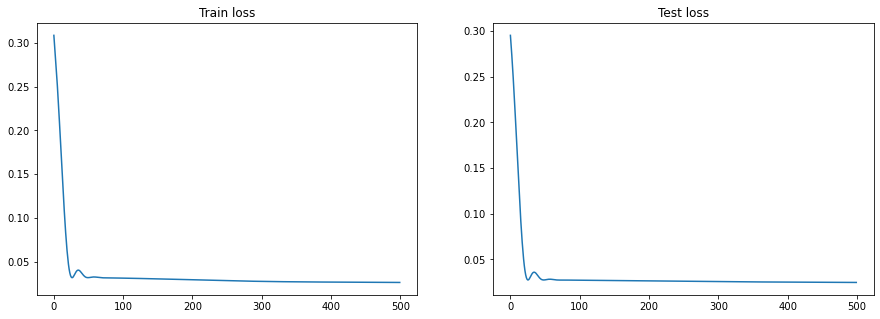

In [51]:
plot_history(history)

In [58]:
autoencoder.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 650, 1)]          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 650, 16)           64        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 325, 16)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 325, 1)            49        
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 163, 1)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 163, 1)            4         
_________________________________________________________________
up_sampling1d_2 (UpSampling1 (None, 326, 1)            0   

In [34]:
#pd.DataFrame(encoder.predict(test_set_scaled))

## Hyper-parameter Tuning

In [62]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

model_classifier = KerasClassifier(autoencoder, verbose=1, batch_size=10, epochs=10)
# define the grid search parameters
#dimensions = []
#dropout = []
batch_size = [10,20]
loss = ['mean_squared_error', 'binary_crossentropy']
optimizer = ['Adam', 'SGD', 'RMSprop']
learning_rate = [0.001]
epochs = [10, 15]
scoring = ['accuracy']
cv = [10]
param_grid = dict(optimizer=optimizer, learning_rate=learning_rate, cv=cv,scoring = scoring)
grid = GridSearchCV(cv=[(slice(None), slice(None))], estimator=model_classifier, param_grid=param_grid, n_jobs=1)

## Error
grid_result = grid.fit(training_set_scaled, training_set_scaled)

best_parameters = grid_result.best_params_
best_accuracy = grid_result.best_score_

TypeError: cannot pickle '_thread.RLock' object